In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from unet.unet_model import UNet

import os
# import kaggledatasets
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda')
device

device(type='cuda')

In [3]:
class Imageset(Dataset):
    def __init__(self, dir_path, shape):
        self.dir_path = dir_path
        self.img_shape = shape
        self.img_list = self.read_files(self.dir_path)

    def read_files(self, dir_path):
        file_list = os.listdir(dir_path)
        return file_list
    
    def __getitem__(self, index):

        return torch.Tensor(plt.imread(self.dir_path+self.img_list[index])/128 - 1  ) # /128 - 1 : generalization
#         return plt.imread(self.dir_path+self.img_list[index])

    def __len__(self):
        return len(self.img_list)

In [4]:
monetset = Imageset('./dataset/photo2monet/monet_jpg/', [256,256])
photoset = Imageset('./dataset/photo2monet/photo_jpg/', [256,256])


monet_loader = DataLoader(dataset = monetset,
                           batch_size=1,
                           shuffle=True, 
                           num_workers=0)

photo_loader = DataLoader(dataset = photoset,
                           batch_size=1,
                           shuffle=True, 
                           num_workers=0)

In [5]:
def downsample_noins(in_dim, out_dim, size):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=size, stride=2, padding=1),
        nn.LeakyReLU(),
    )
    return model

In [6]:
def downsample(in_dim, out_dim, size):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=size, stride=2, padding=1),
        nn.InstanceNorm2d(out_dim),
        nn.LeakyReLU(),
    )
    return model

In [7]:
class Discriminator(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Discriminator, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        act_fn = nn.LeakyReLU(0.2, inplace=True)
        
        
        ## init Unet
        self.down_1 = downsample_noins(3,64,4)
        self.down_2 = downsample(64,128,4)
        self.down_3 = downsample(128,256,4)
        self.down_4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=2),
            nn.InstanceNorm2d(512),
            nn.Tanh(),
        )
        self.last = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid(),
        )
        
        
    def forward(self, input):

        d_1 = self.down_1(input) # [b,64,128,128]
        d_2 = self.down_2(d_1) # [b,128,64,64]
        d_3 = self.down_3(d_2) # [b, 256,32,32]
        d_4 = self.down_4(d_3) # [b, 512,33,33]
        out = self.last(d_4) # [b, 1,30,30]
        return out

In [8]:
def generator_loss(generated):
    return nn.BCELoss()(generated, torch.ones(generated.shape).to(device))

In [9]:
def discriminator_loss(real, generated):
    real_loss = nn.BCEWithLogitsLoss()(real, torch.ones(real.shape).to(device))
    generated_loss =  nn.BCEWithLogitsLoss()(generated, torch.zeros(generated.shape).to(device))
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss*0.5

In [10]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss = torch.mean(torch.abs(real_image - cycled_image))
    return LAMBDA * loss

In [11]:
def identity_loss(real_image, same_image, LAMBDA):
    loss = torch.mean(torch.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [12]:
class CycleGAN(nn.Module):
    def __init__(self, lambda_cycle=10):
        super(CycleGAN, self).__init__()
        self.lambda_cycle=lambda_cycle
        self.m_gen = UNet(3,3)
        self.p_gen = UNet(3,3)
        self.m_disc = Discriminator(256,3)
        self.p_disc = Discriminator(256,3)
        
        self.gen_loss_fn = generator_loss
        self.disc_loss_fn = discriminator_loss
        self.cycle_loss_fn = calc_cycle_loss
        self.identity_loss_fn = identity_loss
        
    def forward(self, batch_data):
        real_monet = batch_data[0]
        real_photo = batch_data[1]
        
        # photo to monet back to photo
        fake_monet = self.m_gen(real_photo.permute(0,3,1,2)).permute(0,2,3,1)
        cycled_photo = self.p_gen(fake_monet.permute(0,3,1,2)).permute(0,2,3,1)
        
        # monet to photo back to monet 
        fake_photo = self.p_gen(real_monet.permute(0,3,1,2)).permute(0,2,3,1)
        cycled_monet = self.m_gen(fake_photo.permute(0,3,1,2)).permute(0,2,3,1)
        
        # generating itself
        same_monet = self.m_gen(real_monet.permute(0,3,1,2)).permute(0,2,3,1)
        same_photo = self.p_gen(real_photo.permute(0,3,1,2)).permute(0,2,3,1)
        
        # discriminator used to check, inputing real images
        disc_real_monet = self.m_disc(real_monet.permute(0,3,1,2))
        disc_real_photo = self.p_disc(real_photo.permute(0,3,1,2))
        
        # discriminator used to check, inputing fake images
        disc_fake_monet = self.m_disc(fake_monet.permute(0,3,1,2))
        disc_fake_photo = self.p_disc(fake_photo.permute(0,3,1,2))
        
        # evaluates generator loss
        monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
        photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
        
        # evaluates total cycle consistency loss
        total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle)
        
        # evaluates total generator loss
        total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
        total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
        
        # evaluates discriminator loss
        monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
        photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
        
        return total_monet_gen_loss, total_photo_gen_loss, monet_disc_loss, photo_disc_loss

In [13]:
model = CycleGAN().to(device)

In [14]:
optimizer = optim.Adam(model.parameters(), lr=2e-4, amsgrad=False)

In [15]:
def train():
    model.train()
    
    monet_iter = iter(monet_loader)
    photo_iter = iter(photo_loader)
#     loss = []
    for a,b in zip(enumerate(monet_iter), enumerate(photo_iter)):

        optimizer.zero_grad()
        total_monet_gen_loss, total_photo_gen_loss, monet_disc_loss, photo_disc_loss = model([a[1].to(device),b[1].to(device)])
#         loss.append(total_monet_gen_loss.item)
        total_monet_gen_loss.backward(retain_graph = True)
        total_photo_gen_loss.backward(retain_graph = True)
        monet_disc_loss.backward()
        photo_disc_loss.backward()
        
        optimizer.step()
        
#     return np.mean(loss)

In [16]:
epochs = 25
for i in range(1, epochs+1):
    print('epoch:', i)
    loss = train()
    print(loss)

epoch: 1


KeyboardInterrupt: 

In [ ]:
# torch.save(model.state_dict(), "model")

In [19]:
model.load_state_dict(torch.load('./model'))

<All keys matched successfully>

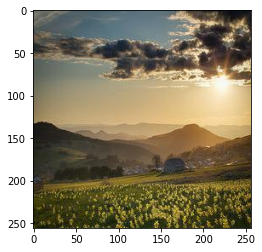

In [20]:
pic = photoset.__getitem__(0)
pic += 1
pic *= 128
plt.imshow( pic.long().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


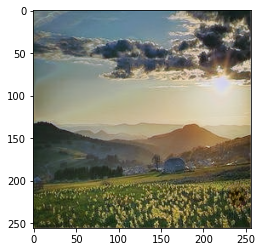

In [21]:
with torch.no_grad():
    generated = model.m_gen(pic.unsqueeze(0).permute(0,3,1,2).to(device) ).permute(0,2,3,1)
    generated += 1
    generated *= 128
    generated = generated.to('cpu').squeeze(0).numpy().astype('long')
    plt.imshow(generated)